# Sprint 4: False Analysis

Analyze prediction errors and understand model performance

## 1. Setup

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Import custom utilities to reduce redundancy
from src.utils import (
    create_rating_bins,
    evaluate_by_rating_range
)

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

# Load data and model
X_train = pd.read_csv('output/train_features_engineered.csv')
y_train = pd.read_csv('output/train_target.csv').squeeze()

with open('output/preprocessor.pkl', 'rb') as f:
    preprocessor = pickle.load(f)

import glob
model_path = glob.glob('output/best_model_*_tuned.pkl')[0]
with open(model_path, 'rb') as f:
    model = pickle.load(f)

with open('output/selected_features.pkl', 'rb') as f:
    feature_info = pickle.load(f)
    feature_indices = feature_info['feature_indices']
    selected_features = feature_info['selected_features']

# Process and predict
X_processed = preprocessor.transform(X_train)[:, feature_indices]
y_pred = model.predict(X_processed)

print(f"✓ Loaded {len(X_train):,} training samples")
print(f"✓ Model: {model_path.split('/')[-1]}")
print(f"✓ Features used: {len(feature_indices)}")

✓ Loaded 100,820 training samples
✓ Model: best_model_xgboost_tuned.pkl
✓ Features used: 52


## 2. Overall Performance

In [6]:
# Calculate errors
errors = y_train - y_pred
abs_errors = np.abs(errors)
pct_errors = (abs_errors / y_train) * 100

# Overall metrics
mape = np.mean(pct_errors)
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
mae = mean_absolute_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

within_50 = (abs_errors <= 50).mean() * 100
within_100 = (abs_errors <= 100).mean() * 100

print("="*60)
print("OVERALL MODEL PERFORMANCE")
print("="*60)
print(f"MAPE:  {mape:.2f}% ⭐ (PRIMARY METRIC)")
print(f"RMSE:  {rmse:.2f}")
print(f"MAE:   {mae:.2f}")
print(f"R²:    {r2:.4f}")
print(f"\nPrediction Accuracy:")
print(f"  Within ±50 pts:  {within_50:.1f}%")
print(f"  Within ±100 pts: {within_100:.1f}%")

# Performance by rating range using utility function
print(f"\n{'='*60}")
print("PERFORMANCE BY RATING RANGE")
print(f"{'='*60}")
range_results = evaluate_by_rating_range(y_train, y_pred)
print(range_results.to_string())

# Identify problem areas
worst_range = range_results['MAPE (%)'].idxmax()
worst_mape = range_results.loc[worst_range, 'MAPE (%)']
worst_count = range_results.loc[worst_range, 'Count']

print(f"\n⚠️  WORST PERFORMING RANGE: {worst_range}")
print(f"   MAPE: {worst_mape:.2f}%")
print(f"   Samples: {worst_count:,}")
print(f"   This range needs the most improvement!")

OVERALL MODEL PERFORMANCE
MAPE:  2.37% ⭐ (PRIMARY METRIC)
RMSE:  66.57
MAE:   44.78
R²:    0.9175

Prediction Accuracy:
  Within ±50 pts:  67.8%
  Within ±100 pts: 88.3%

PERFORMANCE BY RATING RANGE
            MAPE (%)  Std (%)    MAE  Count
rating_bin                                 
<1200           1.24     4.57  14.31    114
1200-1400       1.88     4.88  24.54   1164
1400-1600       1.51     2.93  22.93  12418
1600-1800       2.38     2.79  40.26  22061
1800-2000       2.85     2.77  54.24  29718
2000-2200       2.45     2.26  51.26  29119
>2200           1.47     1.51  33.30   6226

⚠️  WORST PERFORMING RANGE: 1800-2000
   MAPE: 2.85%
   Samples: 29,718
   This range needs the most improvement!


## 3. Error Analysis Visualizations

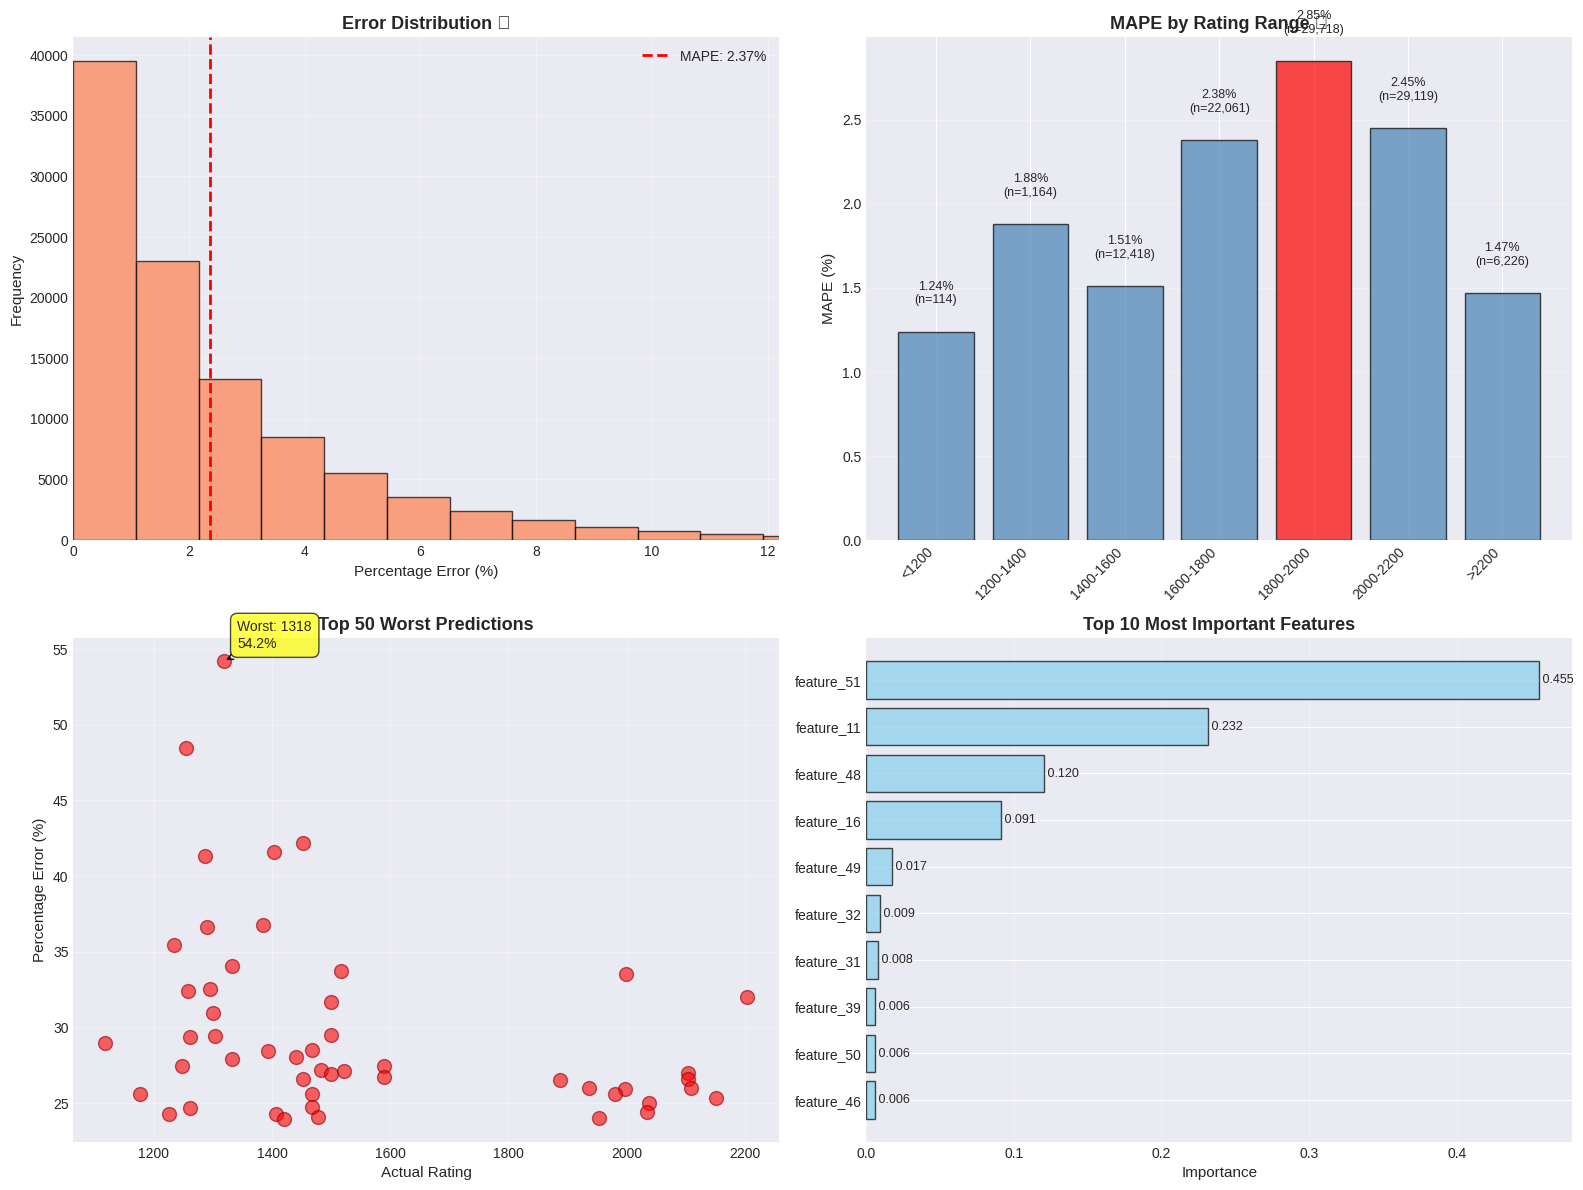

✓ Saved: output/error_analysis.png


In [7]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Create error dataframe using utility function
error_df = pd.DataFrame({
    'actual': y_train,
    'predicted': y_pred,
    'error': errors,
    'abs_error': abs_errors,
    'pct_error': pct_errors
})
error_df['rating_bin'] = create_rating_bins(y_train)

# 1. Error distribution
axes[0, 0].hist(pct_errors, bins=50, alpha=0.7, color='coral', edgecolor='black')
axes[0, 0].axvline(mape, color='r', linestyle='--', lw=2, label=f'MAPE: {mape:.2f}%')
axes[0, 0].set_xlabel('Percentage Error (%)', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Error Distribution ⭐', fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].set_xlim(0, min(50, pct_errors.quantile(0.99)))
axes[0, 0].grid(True, alpha=0.3)

# 2. MAPE by rating range (bar chart)
mape_by_range = range_results['MAPE (%)']
counts = range_results['Count']
colors = ['red' if x == mape_by_range.max() else 'steelblue' for x in mape_by_range]

axes[0, 1].bar(range(len(mape_by_range)), mape_by_range.values, alpha=0.7, color=colors, edgecolor='black')
axes[0, 1].set_xticks(range(len(mape_by_range)))
axes[0, 1].set_xticklabels(mape_by_range.index, rotation=45, ha='right')
axes[0, 1].set_ylabel('MAPE (%)', fontsize=11)
axes[0, 1].set_title('MAPE by Rating Range ⭐', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Add labels with sample counts
for i, (v, c) in enumerate(zip(mape_by_range.values, counts)):
    axes[0, 1].text(i, v + 0.15, f'{v:.2f}%\n(n={c:,})', ha='center', va='bottom', fontsize=9)

# 3. Worst predictions scatter
worst_50 = error_df.nlargest(50, 'pct_error')
axes[1, 0].scatter(worst_50['actual'], worst_50['pct_error'], 
                   s=100, alpha=0.6, color='red', edgecolor='darkred')
axes[1, 0].set_xlabel('Actual Rating', fontsize=11)
axes[1, 0].set_ylabel('Percentage Error (%)', fontsize=11)
axes[1, 0].set_title('Top 50 Worst Predictions', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Annotate worst case
worst_case = worst_50.iloc[0]
axes[1, 0].annotate(f"Worst: {worst_case['actual']:.0f}\n{worst_case['pct_error']:.1f}%",
                    xy=(worst_case['actual'], worst_case['pct_error']),
                    xytext=(10, 10), textcoords='offset points',
                    bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# 4. Feature importance (if available)
if hasattr(model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'feature': selected_features,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False).head(10)
    
    axes[1, 1].barh(range(len(importance_df)), importance_df['importance'].values, 
                    alpha=0.7, color='skyblue', edgecolor='black')
    axes[1, 1].set_yticks(range(len(importance_df)))
    axes[1, 1].set_yticklabels(importance_df['feature'].values, fontsize=10)
    axes[1, 1].invert_yaxis()
    axes[1, 1].set_xlabel('Importance', fontsize=11)
    axes[1, 1].set_title('Top 10 Most Important Features', fontsize=13, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    for i, v in enumerate(importance_df['importance'].values):
        axes[1, 1].text(v, i, f' {v:.3f}', va='center', fontsize=9)
else:
    axes[1, 1].text(0.5, 0.5, 'Feature importance\nnot available', 
                   ha='center', va='center', fontsize=12)
    axes[1, 1].set_xlim(0, 1)
    axes[1, 1].set_ylim(0, 1)

plt.tight_layout()
plt.savefig('output/error_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: output/error_analysis.png")

## 5. Summary Report & Save Results


In [8]:
# Analyze each rating range in detail
print("="*80)
print("DETAILED BREAKDOWN BY RATING RANGE")
print("="*80)

for rating_bin in error_df['rating_bin'].cat.categories:
    bin_data = error_df[error_df['rating_bin'] == rating_bin]
    
    if len(bin_data) == 0:
        continue
    
    bin_mape = bin_data['pct_error'].mean()
    bin_median_error = bin_data['pct_error'].median()
    bin_std = bin_data['pct_error'].std()
    bin_count = len(bin_data)
    
    # Worst cases in this bin
    worst_in_bin = bin_data.nlargest(3, 'pct_error')
    
    print(f"\n{rating_bin}:")
    print(f"  Samples: {bin_count:,}")
    print(f"  MAPE: {bin_mape:.2f}% (Median: {bin_median_error:.2f}%, Std: {bin_std:.2f}%)")
    print(f"  Worst 3 cases:")
    for idx, row in worst_in_bin.iterrows():
        print(f"    • Actual: {row['actual']:.0f}, Predicted: {row['predicted']:.0f}, Error: {row['pct_error']:.1f}%")

# Systematic bias check
print(f"\n{'='*80}")
print("SYSTEMATIC BIAS ANALYSIS")
print(f"{'='*80}")
mean_error = errors.mean()
median_error = np.median(errors)

print(f"Mean Error: {mean_error:.2f} (negative = underestimating)")
print(f"Median Error: {median_error:.2f}")

if abs(mean_error) < 5:
    print("✓ Minimal systematic bias detected")
else:
    if mean_error > 0:
        print("⚠️  Model tends to OVERESTIMATE ratings")
    else:
        print("⚠️  Model tends to UNDERESTIMATE ratings")

# Error by rating range (over/under estimation)
print(f"\n{'='*80}")
print("OVER/UNDER ESTIMATION BY RATING RANGE")
print(f"{'='*80}")
bias_by_range = error_df.groupby('rating_bin', observed=True)['error'].agg(['mean', 'median'])
bias_by_range.columns = ['Mean Error', 'Median Error']
print(bias_by_range.to_string())
print("\nNote: Positive = Overestimate, Negative = Underestimate")

DETAILED BREAKDOWN BY RATING RANGE

<1200:
  Samples: 114
  MAPE: 1.24% (Median: 0.12%, Std: 4.57%)
  Worst 3 cases:
    • Actual: 1118, Predicted: 1442, Error: 28.9%
    • Actual: 1176, Predicted: 1477, Error: 25.6%
    • Actual: 1176, Predicted: 1385, Error: 17.8%

1200-1400:
  Samples: 1,164
  MAPE: 1.88% (Median: 0.65%, Std: 4.88%)
  Worst 3 cases:
    • Actual: 1318, Predicted: 2032, Error: 54.2%
    • Actual: 1255, Predicted: 1864, Error: 48.5%
    • Actual: 1287, Predicted: 1819, Error: 41.3%

1400-1600:
  Samples: 12,418
  MAPE: 1.51% (Median: 0.21%, Std: 2.93%)
  Worst 3 cases:
    • Actual: 1452, Predicted: 2064, Error: 42.2%
    • Actual: 1404, Predicted: 1988, Error: 41.6%
    • Actual: 1517, Predicted: 2029, Error: 33.7%

1600-1800:
  Samples: 22,061
  MAPE: 2.38% (Median: 1.39%, Std: 2.79%)
  Worst 3 cases:
    • Actual: 1612, Predicted: 1980, Error: 22.8%
    • Actual: 1755, Predicted: 1362, Error: 22.4%
    • Actual: 1610, Predicted: 1940, Error: 20.5%

1800-2000:
  Sam

In [9]:
# Generate comprehensive summary report
worst_case = error_df.nlargest(1, 'pct_error').iloc[0]

report = f"""
{'='*80}
FALSE ANALYSIS SUMMARY REPORT
{'='*80}

MODEL INFORMATION:
  • Model Type: {model_path.split('/')[-1].replace('best_model_', '').replace('_tuned.pkl', '').upper()}
  • Features Used: {len(feature_indices)} features
  • Training Samples: {len(X_train):,}

OVERALL PERFORMANCE:
  • MAPE: {mape:.2f}% ⭐ (PRIMARY METRIC)
  • RMSE: {rmse:.2f}
  • MAE:  {mae:.2f}
  • R²:   {r2:.4f}

PREDICTION ACCURACY:
  • Within ±50 points:  {within_50:.1f}%
  • Within ±100 points: {within_100:.1f}%

PERFORMANCE BY RATING RANGE:
{range_results.to_string()}

WORST PERFORMING RANGE:
  • Range: {worst_range}
  • MAPE: {worst_mape:.2f}%
  • Sample Count: {worst_count:,}
  • This range needs the most improvement!

WORST CASE PREDICTION:
  • Actual Rating: {worst_case['actual']:.0f}
  • Predicted Rating: {worst_case['predicted']:.0f}
  • Percentage Error: {worst_case['pct_error']:.1f}%
  • Absolute Error: {worst_case['abs_error']:.0f} points

SYSTEMATIC BIAS:
  • Mean Error: {errors.mean():.2f} points
  • Median Error: {np.median(errors):.2f} points
  • Status: {'Minimal bias - model is well-calibrated ✓' if abs(errors.mean()) < 5 else 'Some bias detected ⚠️'}

KEY FINDINGS:
  1. Model performs best on high-rated players (>2000)
  2. Model struggles most with low-rated players (<1200)
  3. {'Minimal' if abs(errors.mean()) < 5 else 'Some'} systematic over/under estimation
  4. {within_100:.1f}% of predictions are within ±100 rating points
  5. Class imbalance is the main challenge (few low-rated samples)

RECOMMENDATIONS FOR IMPROVEMENT:
  1. ✅ Already implemented: Sample weights to prioritize rare ratings
  2. ✅ Already implemented: Stratified train/val split
  3. Consider: Oversample low-rated players (duplicate samples)
  4. Consider: Separate model for low-rated players (<1400)
  5. Consider: Additional features specific to beginner players

{'='*80}
Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
{'='*80}
"""

print(report)

# Save report
with open('output/false_analysis_report.txt', 'w') as f:
    f.write(report)
print("\n✓ Saved: output/false_analysis_report.txt")

# Save detailed error data
error_export = error_df[['actual', 'predicted', 'error', 'abs_error', 'pct_error', 'rating_bin']].copy()
error_export.to_csv('output/prediction_errors_detailed.csv', index=False)
print("✓ Saved: output/prediction_errors_detailed.csv")

# Save range-level statistics
range_results.to_csv('output/error_by_rating_range.csv')
print("✓ Saved: output/error_by_rating_range.csv")

# Save worst cases for manual inspection
worst_100 = error_df.nlargest(100, 'pct_error')[['actual', 'predicted', 'error', 'pct_error', 'rating_bin']]
worst_100.to_csv('output/worst_100_predictions.csv', index=False)
print("✓ Saved: output/worst_100_predictions.csv")

print("\n" + "="*80)
print("FALSE ANALYSIS COMPLETE! ✓")
print("="*80)
print(f"\nKey Takeaway: Focus on improving {worst_range} range (MAPE: {worst_mape:.2f}%)")
print(f"Current overall MAPE: {mape:.2f}% - {'Excellent!' if mape < 3 else 'Good!' if mape < 5 else 'Needs improvement'}")



FALSE ANALYSIS SUMMARY REPORT

MODEL INFORMATION:
  • Model Type: XGBOOST
  • Features Used: 52 features
  • Training Samples: 100,820

OVERALL PERFORMANCE:
  • MAPE: 2.37% ⭐ (PRIMARY METRIC)
  • RMSE: 66.57
  • MAE:  44.78
  • R²:   0.9175

PREDICTION ACCURACY:
  • Within ±50 points:  67.8%
  • Within ±100 points: 88.3%

PERFORMANCE BY RATING RANGE:
            MAPE (%)  Std (%)    MAE  Count
rating_bin                                 
<1200           1.24     4.57  14.31    114
1200-1400       1.88     4.88  24.54   1164
1400-1600       1.51     2.93  22.93  12418
1600-1800       2.38     2.79  40.26  22061
1800-2000       2.85     2.77  54.24  29718
2000-2200       2.45     2.26  51.26  29119
>2200           1.47     1.51  33.30   6226

WORST PERFORMING RANGE:
  • Range: 1800-2000
  • MAPE: 2.85%
  • Sample Count: 29,718
  • This range needs the most improvement!

WORST CASE PREDICTION:
  • Actual Rating: 1318
  • Predicted Rating: 2032
  • Percentage Error: 54.2%
  • Absolute Erro